# **1. MNIST Classification Using RNN**

## Importing the necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math
import torch.nn.functional as F

## Data Preparation

In [3]:
MNIST_train = datasets.MNIST(root='./data', train = True , download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
MNIST_test = datasets.MNIST(root='./data', train = False ,download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 121773992.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15552149.68it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 148272868.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17787608.56it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_set, val_set = torch.utils.data.random_split(MNIST_train, [50000, 10000])

In [5]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)

val_data = torch.utils.data.DataLoader(val_set, batch_size=100,shuffle=True)

test_data = torch.utils.data.DataLoader(MNIST_test, batch_size=100,shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
print("Dataset Length =",len(MNIST_train))
print("Train Dataset Length =",len(train_set))
print("Validation Dataset Length =",len(val_set))
print("Test Dataset Length =",len(MNIST_test))

Dataset Length = 60000
Train Dataset Length = 50000
Validation Dataset Length = 10000
Test Dataset Length = 10000


First, the vanilla RNN model:

In [7]:
class RNN(nn.Module):

    def __init__(self,input_dim,hidden_dim,output_dim,num_lay, bi = False):

        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_lay

        self.rnn = nn.RNN(input_dim, hidden_dim, num_lay,bidirectional=bi)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):

        X = X.permute(1, 0, 2)
        hiddenlayer=torch.zeros(num_layers,X.size(1),hidden_dim,device=device)
        out,hiddenlayer = self.rnn(X,hiddenlayer.detach())
        out = self.layer2(out[-1,:,:])
        return out.reshape(100,10)

class BIRNN(nn.Module):

    def __init__(self,input_dim,hidden_dim,output_dim,num_lay, bi = False):

        super(BIRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_lay

        self.rnn = nn.RNN(input_dim, hidden_dim, num_lay,bidirectional=bi)
        self.layer2 = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, X):

        X = X.permute(1, 0, 2)
        hiddenlayer=torch.zeros(2*num_layers,X.size(1),hidden_dim,device=device)
        out,hiddenlayer = self.rnn(X,hiddenlayer.detach())
        finp,binp=hiddenlayer[0],hiddenlayer[1]
        inp=torch.cat((finp,binp),dim=-1)
        out = self.layer2(inp)
        return out

def plot_metrics(res):
    fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))
    train.plot(res["train_loss"])
    train.title.set_text("Training loss per iteration last epoch")


    valida.plot(res["val_loss"])
    valida.title.set_text("Validation loss per epoch")

    acc.plot(res["val_acc"])
    acc.title.set_text("Validation Accuracy per epoch")

In [8]:
classes = 10
epochs = 10
batch_size = 100
seq_len = 28
input_dim = 28
hidden_dim = 128
num_layers = 1
output_dim = 10
learning_rate = 0.002
epochs = 10
regul=0.01
loss_fn= nn.CrossEntropyLoss()

In [9]:
def train_model(model,epoch,train_loader,val_loader,regularization = 0):
    metrics = {"train_loss": [],"val_loss": [],"val_acc": []}
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epoch):
        for i, (images, labels) in enumerate(train_loader):

            img = images.to(device)
            target = labels.to(device)

            img = img.reshape(-1, 28, 28)
            outputs = model(img)
            if (regularization != 0):
                loss = loss_fn(outputs, target) + regularization*torch.norm(model.layer2.weight)
            else:
                loss = loss_fn(outputs, target)
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        iteration=0
        tempvalloss=0
        correctval=0
        for images, labels in val_loader:
            img = images.to(device)
            target = labels.to(device)

            img = img.reshape(-1, 28, 28)
            outputs = model(img)
            loss = loss_fn(outputs, target)
            _, predicted = torch.max(outputs.data, 1)
            correctval += (predicted == target).sum().item()
            iteration+=1
            tempvalloss+=loss.item()

        metrics["val_loss"].append(tempvalloss/iteration)
        metrics["val_acc"].append(correctval/100)
        print("Epoch :" , epoch +1 , "val_loss :" ,round(metrics["val_loss"][-1],3), "val_acc :" ,metrics["val_acc"][-1])
    return model,metrics

In [10]:
def test_model(model,test_loader):
    metrics = {"test_acc": []}
    model.to(device)

    iteration=0
    correctval=0
    for images, labels in test_loader:
        img = images.to(device)
        target = labels.to(device)

        img = img.reshape(-1, 28, 28)
        outputs = model(img)
        loss = loss_fn(outputs, target)
        _, predicted = torch.max(outputs.data, 1)
        correctval += (predicted == target).sum().item()
        iteration+=1

    metrics["test_acc"].append(correctval/100)
    print("Test Accuracy :",metrics["test_acc"][-1])
    return metrics

In [11]:
model,res = train_model(RNN(input_dim,hidden_dim,output_dim,num_layers),10,train_data,val_data)

Epoch : 1 val_loss : 0.426 val_acc : 86.99
Epoch : 2 val_loss : 0.305 val_acc : 91.01
Epoch : 3 val_loss : 0.192 val_acc : 94.69
Epoch : 4 val_loss : 0.181 val_acc : 94.87
Epoch : 5 val_loss : 0.199 val_acc : 94.62
Epoch : 6 val_loss : 0.138 val_acc : 96.08
Epoch : 7 val_loss : 0.214 val_acc : 93.8
Epoch : 8 val_loss : 0.158 val_acc : 95.73
Epoch : 9 val_loss : 0.143 val_acc : 96.25
Epoch : 10 val_loss : 0.209 val_acc : 94.2


In [12]:
test_model(model,test_data)

Test Accuracy : 94.26


{'test_acc': [94.26]}

Plotting the training, test and validation errors.

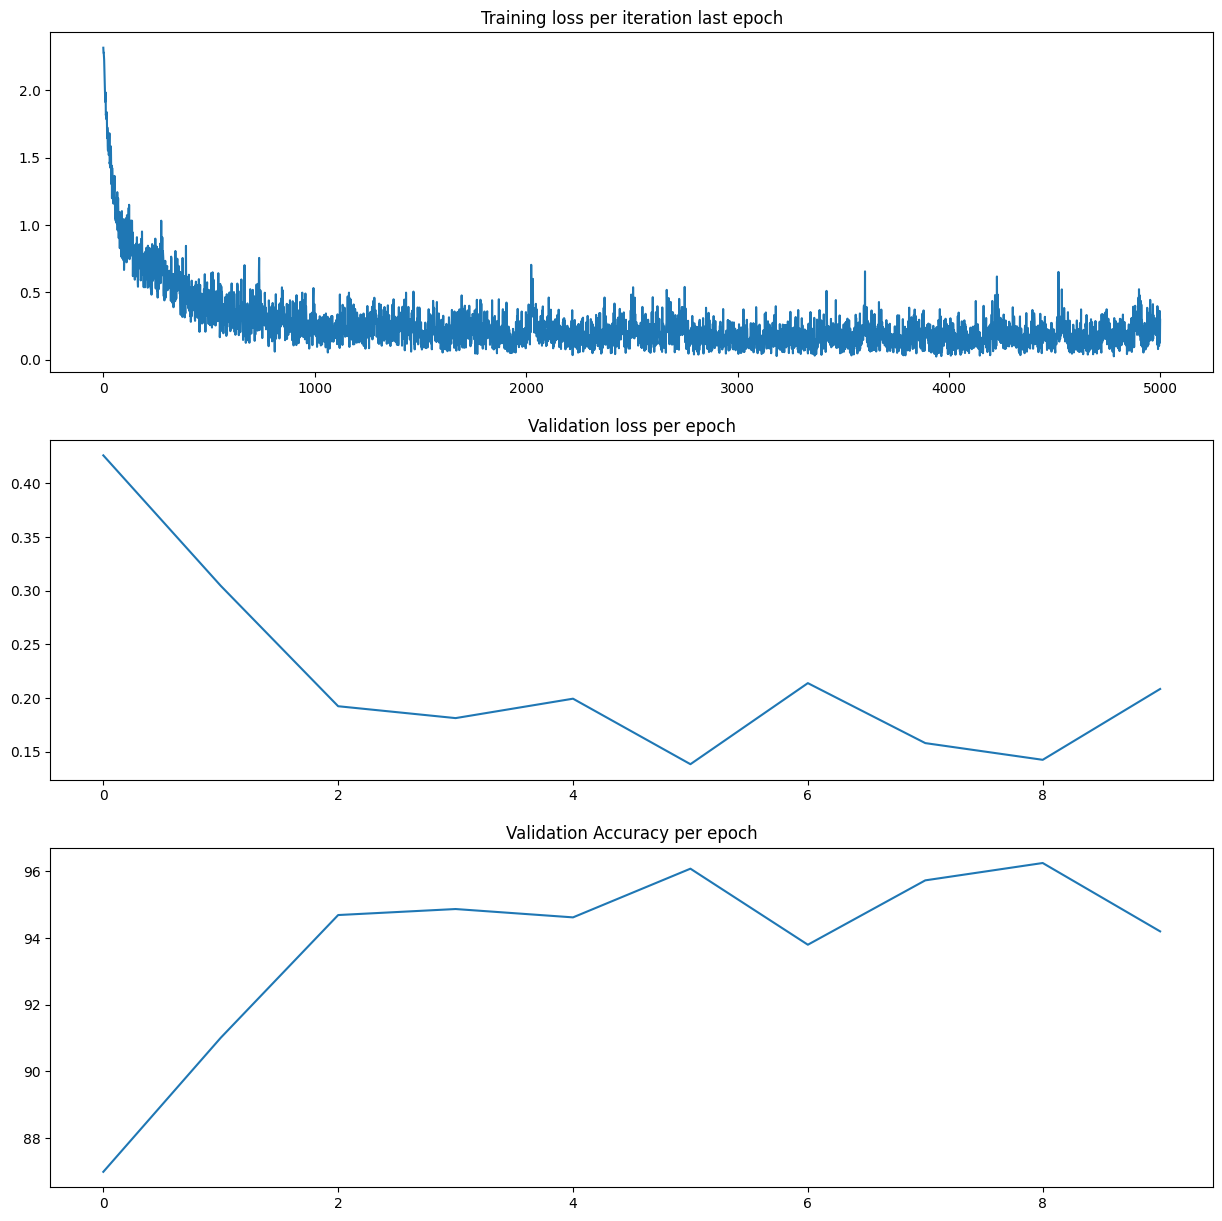

In [13]:
plot_metrics(res)

Next, redoing it with LSTM:

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bi = False):

        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,bidirectional=bi)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):

        hiddenlayer = torch.zeros(self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        cellstatelayer = torch.zeros(self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        X = X.permute(1, 0, 2)

        out, (hn,cn) = self.lstm(X, (hiddenlayer.detach(),cellstatelayer.detach()))
        out = self.fc(out[-1])
        return out.reshape(100,10)

class BILSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bi = False):

        super(BILSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,bidirectional=bi)
        self.fc = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, X):

        hiddenlayer = torch.zeros(2*self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        cellstatelayer = torch.zeros(2*self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        X = X.permute(1, 0, 2)

        out, (hn,cn) = self.lstm(X, (hiddenlayer.detach(),cellstatelayer.detach()))
        out = self.fc(out[-1])
        return out.reshape(100,10)

In [16]:
model_lstm,res_lstm = train_model(LSTM(input_dim,hidden_dim,output_dim,num_layers),10,train_data,val_data)

Epoch : 1 val_loss : 0.132 val_acc : 96.27
Epoch : 2 val_loss : 0.09 val_acc : 97.31
Epoch : 3 val_loss : 0.073 val_acc : 98.01
Epoch : 4 val_loss : 0.074 val_acc : 97.81
Epoch : 5 val_loss : 0.063 val_acc : 98.18
Epoch : 6 val_loss : 0.064 val_acc : 98.26
Epoch : 7 val_loss : 0.062 val_acc : 98.39
Epoch : 8 val_loss : 0.059 val_acc : 98.46
Epoch : 9 val_loss : 0.062 val_acc : 98.41
Epoch : 10 val_loss : 0.075 val_acc : 98.07


In [17]:
test_model(model_lstm,test_data)

Test Accuracy : 98.33


{'test_acc': [98.33]}

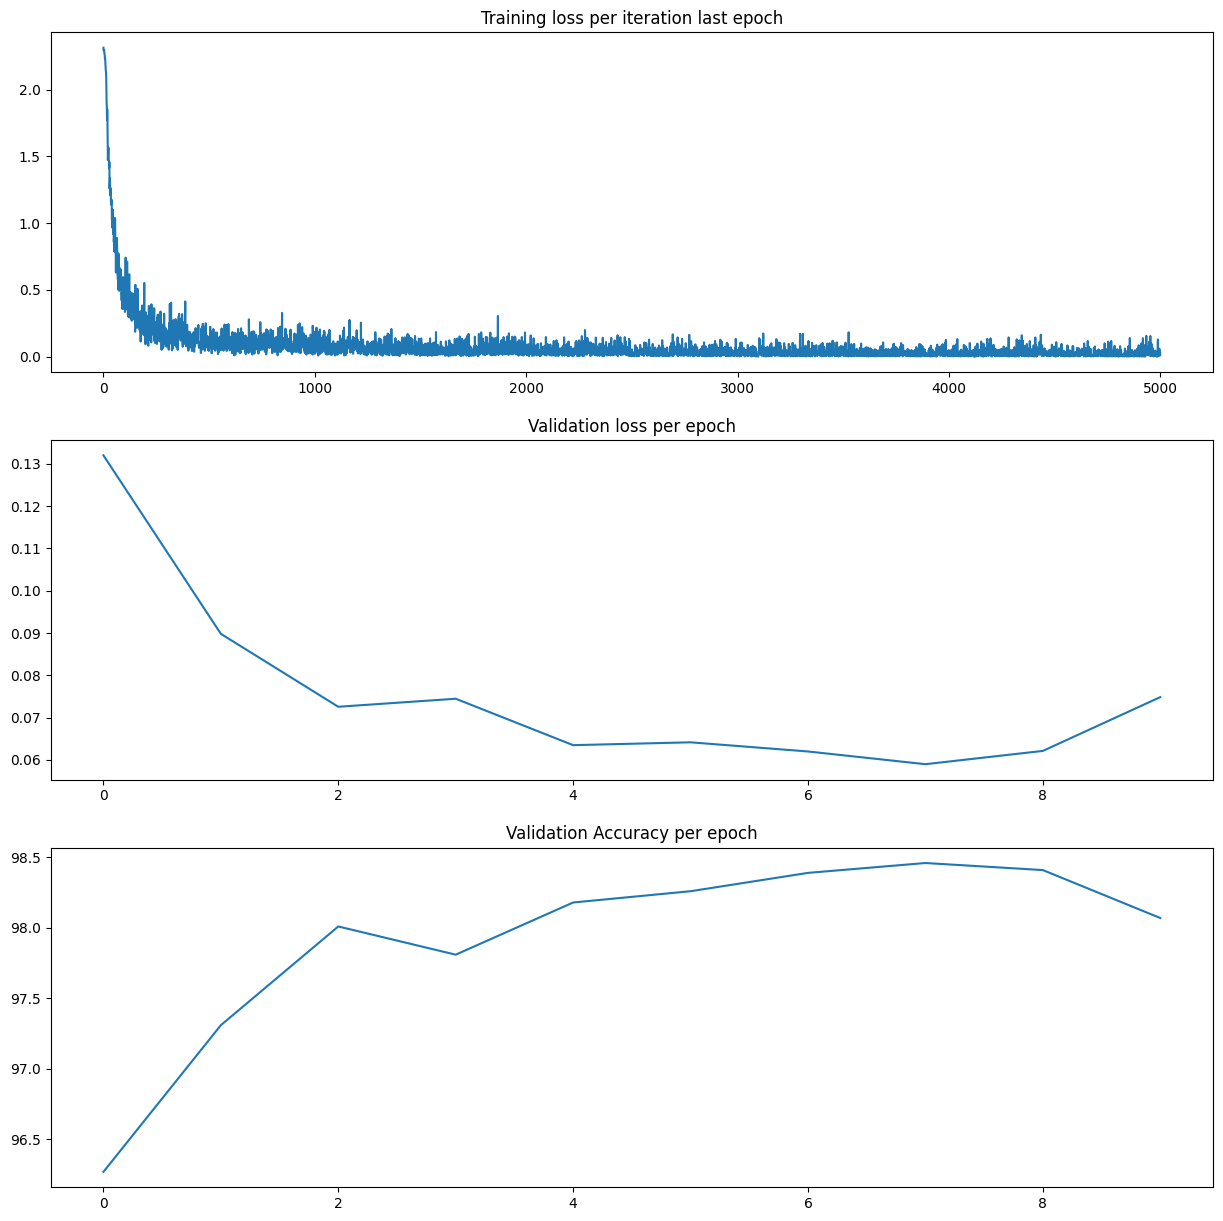

In [18]:
plot_metrics(res_lstm)

Now, using a bidirectional LSTM network

In [20]:
model_bilstm,res_bilstm = train_model(BILSTM(input_dim,hidden_dim,output_dim,num_layers, bi=True),10,train_data,val_data)

Epoch : 1 val_loss : 0.118 val_acc : 96.63
Epoch : 2 val_loss : 0.084 val_acc : 97.62
Epoch : 3 val_loss : 0.066 val_acc : 98.17
Epoch : 4 val_loss : 0.072 val_acc : 97.96
Epoch : 5 val_loss : 0.064 val_acc : 98.25
Epoch : 6 val_loss : 0.054 val_acc : 98.61
Epoch : 7 val_loss : 0.067 val_acc : 98.14
Epoch : 8 val_loss : 0.06 val_acc : 98.38
Epoch : 9 val_loss : 0.056 val_acc : 98.56
Epoch : 10 val_loss : 0.055 val_acc : 98.53


In [21]:
test_model(model_bilstm,test_data)

Test Accuracy : 98.47


{'test_acc': [98.47]}

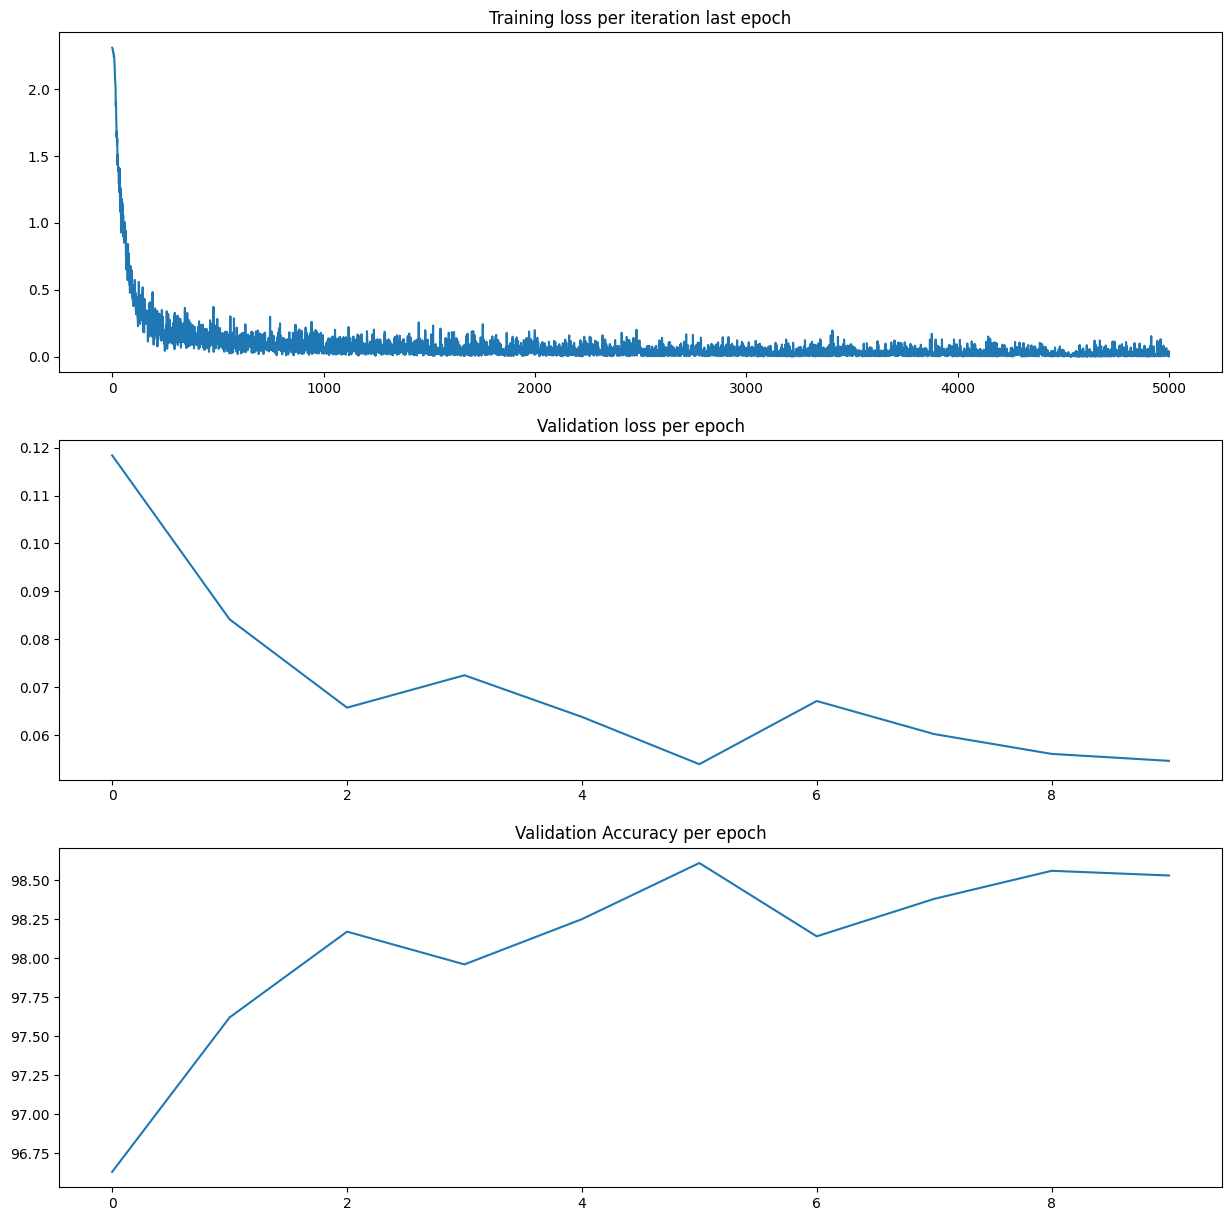

In [22]:
plot_metrics(res_bilstm)

Images:


<ipython-input-23-4a53833ed635>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(1,10,k)


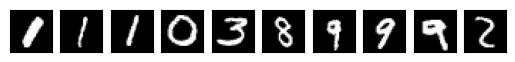

Prediction: [1. 1. 1. 0. 3. 8. 9. 9. 9. 2.]
Real label: [1. 1. 1. 0. 3. 8. 9. 9. 9. 2.]


In [23]:
k=1
print('Images:')
a=(10*np.abs(np.random.rand(10))).astype(int)
predict=np.zeros(10)
actual=np.zeros(10)
fig,ax = plt.subplots()
for i in range(10):
    for images,labels in test_data:
        images = images.reshape(-1, 28, 28)
        images = images.to("cuda")
        ax=plt.subplot(1,10,k)
        ax.set_xticks([])
        ax.set_yticks([])
        im=ax.imshow(images[a[i]].cpu().reshape(28,28),cmap='gray')
        _,predicted=torch.max(model_bilstm(images)[a[i]],0)
        predict[i]=predicted.item()
        actual[i]=labels[a[i]]
        break
    k+=1
plt.show()
print('Prediction:',predict)
print('Real label:',actual)

# With Handwritten Digits

In [27]:
from PIL import Image, ImageOps
def binary_image(im):
    image = torch.zeros(im.size[0],im.size[0]).to("cuda")
    for i in range(im.size[0]):
        for j in range(im.size[1]):
            if (im.getpixel((i,j)) >109):
                image[j,i] = 1
            else:
                image[j,i] = 0
    return image.cpu()

In [47]:
%cd /content/digits
!dir

/content/digits
digit\ (10).jpeg  digit\ (2).jpeg  digit\ (4).jpeg  digit\ (6).jpeg  digit\ (8).jpeg
digit\ (1).jpeg   digit\ (3).jpeg  digit\ (5).jpeg  digit\ (7).jpeg  digit\ (9).jpeg


In [54]:
import os
dig = os.listdir()

In [55]:
dig

['9_1.jpeg',
 '6_2.jpeg',
 '7.jpeg',
 '2.jpeg',
 '4.jpeg',
 '8_2.jpeg',
 '9_2.jpeg',
 '.ipynb_checkpoints',
 '6_1.jpeg',
 '0.jpeg',
 '8_1.jpeg']

Images:


<ipython-input-56-72d72e93b15a>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(1,10,k+1)


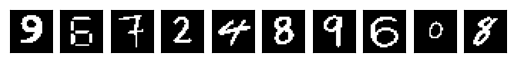

Prediction BILSTM: [8. 8. 5. 8. 8. 8. 8. 5. 5. 8.]
Real label: [9. 6. 7. 2. 4. 8. 9. 6. 0. 8.]


In [56]:
k=0
print('Images:')
predict_rnn=np.zeros(10)
predict_birnn=np.zeros(10)
predict_lstm=np.zeros(10)
predict_bilstm=np.zeros(10)
actual=np.zeros(10)
fig,ax = plt.subplots()
for j in dig:
  if j!= '.ipynb_checkpoints':
    im = Image.open(j).resize((28,28))
    im = ImageOps.grayscale(im)
    image = binary_image(im)
    images = image.repeat(100,1,1)
    images = images.to("cuda")
    ax=plt.subplot(1,10,k+1)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(images[0].cpu().reshape(28,28),cmap='gray')
    _,predicted=torch.max(model_bilstm(images)[0],0)
    predict_bilstm[k]=predicted.item()
    actual[k]=int(j[0][0])
    k+=1
plt.show()
print('Prediction BILSTM:',predict_bilstm)
print('Real label:',actual)



My model performed very poorly on my own data. It seems to classify anything with a hint of curvature or a loop as 8 while anything with a horizontal slash is predicted to be 5. This shows that model with high accuracy on a dataset might still fail in real life scenarios.

# **2. Adding Two Binary Strings**

In [75]:
def bin_gen(L):
    N1=np.random.randint(0,2**(L-1))
    N2=np.random.randint(0,2**(L-1))
    S=N1+N2
    binlen=L
    B1=np.zeros((1,binlen))
    B2=np.zeros((1,binlen))
    B3=np.zeros((binlen))
    b=np.flip(np.array(list(np.binary_repr(N1)), dtype=int))
    B1[0][0:len(b)]=b[0:]
    b=np.flip(np.array(list(np.binary_repr(N2)), dtype=int))
    B2[0][0:len(b)]=b[0:]
    b=np.flip(np.array(list(np.binary_repr(S)), dtype=int))
    B3[0:len(b)]=b[0:]
    return(np.concatenate((np.transpose(B1),np.transpose(B2)),axis=1),B3)

In [76]:
def generate_data(size,l=3):
    data=[]
    target=[]
    for i in range(size):
        a,b=bin_gen(l)
        data.append(a)
        target.append(b)
    return data,target

In [77]:
generate_data(1,8)

([array([[1., 1.],
         [0., 1.],
         [1., 0.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [0., 0.]])],
 [array([0., 0., 0., 1., 1., 1., 1., 1.])])

In [78]:
class LSTM_bit_add(nn.Module):

    def __init__(self,hidsize):
        super(LSTM_bit_add, self).__init__()
        self.hidsize=hidsize
        self.lstm = nn.LSTM(2,hidsize)
        self.layer2 = nn.Sequential(
            nn.Linear(hidsize,1),
            nn.Sigmoid())

    def forward(self, X):
        X=X.permute(1,0,2)
        hiddenstate=torch.zeros(1,X.size(1),self.hidsize)
        cellstate=torch.zeros(1,X.size(1),self.hidsize)
        out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate))
        out = self.layer2(out)
        return out.reshape(X.size(0))

In [79]:
loss_cross_entropy = nn.BCELoss()

In [80]:
def train_bin_add(train_input,test_input,hidstate = 3,epochs = 5):
    metrics = {"train_loss": [],"test_loss": [],"correct_test":[]}
    model=LSTM_bit_add(hidstate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for i in range(int(len(train_input[0]))):
            a=torch.zeros((1,train_input[0][i].shape[0],train_input[0][i].shape[1]))
            a[0]=torch.from_numpy(train_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(train_input[1][i]))
            loss = loss_mse(output,label.float())
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        iteration=0
        tempvalloss=0
        correctval=0

        for i in range(len(test_input[0])):
            correct=0
            a=torch.zeros((1,test_input[0][i].shape[0],test_input[0][i].shape[1]))
            a[0]=torch.from_numpy(test_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(test_input[1][i]))
            loss = loss_mse(output,label.float())
            iteration+=1
            tempvalloss+=loss.item()

            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            correct += (predicted == label.float()).sum().item()/len(label)

        metrics["correct_test"].append(100*correct/iteration)
        metrics["test_loss"].append(tempvalloss/iteration)
    return model,metrics

def test_bin_add(model,test_data):
    model.eval()
    correctarr1 = np.zeros(20)
    correctarr2 = np.zeros(20)
    with torch.no_grad():
        for i in range(len(test_data[0])):
            a=torch.zeros((1,test_data[0][i].shape[0],test_data[0][i].shape[1]))
            a[0]=torch.from_numpy(test_data[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(test_data[1][i]))
            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


        print('Bit accuracy :',(np.sum(correctarr1)/20)*100, "%")

def train_bin_add_loss_cross_entropy(train_input,test_input,hidstate = 3,epochs = 5):
    metrics = {"train_loss": [],"test_loss": [],"correct_test":[]}
    model=LSTM_bit_add(hidstate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for i in range(int(len(train_input[0]))):
            a=torch.zeros((1,train_input[0][i].shape[0],train_input[0][i].shape[1]))
            a[0]=torch.from_numpy(train_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(train_input[1][i]))
            loss = loss_cross_entropy(output,label.float())
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        iteration=0
        tempvalloss=0
        correctval=0

        for i in range(len(test_input[0])):
            correct=0
            a=torch.zeros((1,test_input[0][i].shape[0],test_input[0][i].shape[1]))
            a[0]=torch.from_numpy(test_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(test_input[1][i]))
            loss = loss_cross_entropy(output,label.float())
            iteration+=1
            tempvalloss+=loss.item()

            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            correct += (predicted == label.float()).sum().item()/len(label)

        metrics["correct_test"].append(100*correct/iteration)
        metrics["test_loss"].append(tempvalloss/iteration)
    return model,metrics

In [81]:
learning_rate = 0.01
epochs = 5
loss_mse = nn.MSELoss()
train_size = 200
test_size = 100
hidstate = 3

## MSE

In [82]:
model_bin_3,metric_bin_3 = train_bin_add(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,hidstate = hidstate)
model_bin_5,metric_bin_5 = train_bin_add(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5) ,hidstate = hidstate)
model_bin_10,metric_bin_10 = train_bin_add(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10) ,hidstate = hidstate)

In [83]:
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=3))

Bit accuracy : 93.33333333333333 %


In [84]:
test_bin_add(model_bin_5,test_data = generate_data(size = 20,l=5))

Bit accuracy : 92.00000000000001 %


In [85]:
test_bin_add(model_bin_10,test_data = generate_data(size = 20,l=10))

Bit accuracy : 97.00000000000001 %


Accuracy gets better with length of the sequence here. In a longer sequence, there are more places to optimize for same number of epoch and dataset size.

## Cross Entropy Loss

In [86]:
model_bin_3_ce,metric_bin_3_ce = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=3) , test_input = generate_data(size = test_size,l=3) ,hidstate = hidstate)
model_bin_5_ce,metric_bin_5_ce = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=5) , test_input = generate_data(size = test_size,l=5) ,hidstate = hidstate)
model_bin_10_ce,metric_bin_10_ce = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=10) , test_input = generate_data(size = test_size,l=10) ,hidstate = hidstate)

In [87]:
test_bin_add(model_bin_3_ce,test_data = generate_data(size = 20,l=3))

Bit accuracy : 100.0 %


In [88]:
test_bin_add(model_bin_5_ce,test_data = generate_data(size = 20,l=5))

Bit accuracy : 89.0 %


In [89]:
test_bin_add(model_bin_10_ce,test_data = generate_data(size = 20,l=10))

Bit accuracy : 83.5 %


Here however, we see that the bit accuracy reduces with increase in sequence length.

## Training Loss

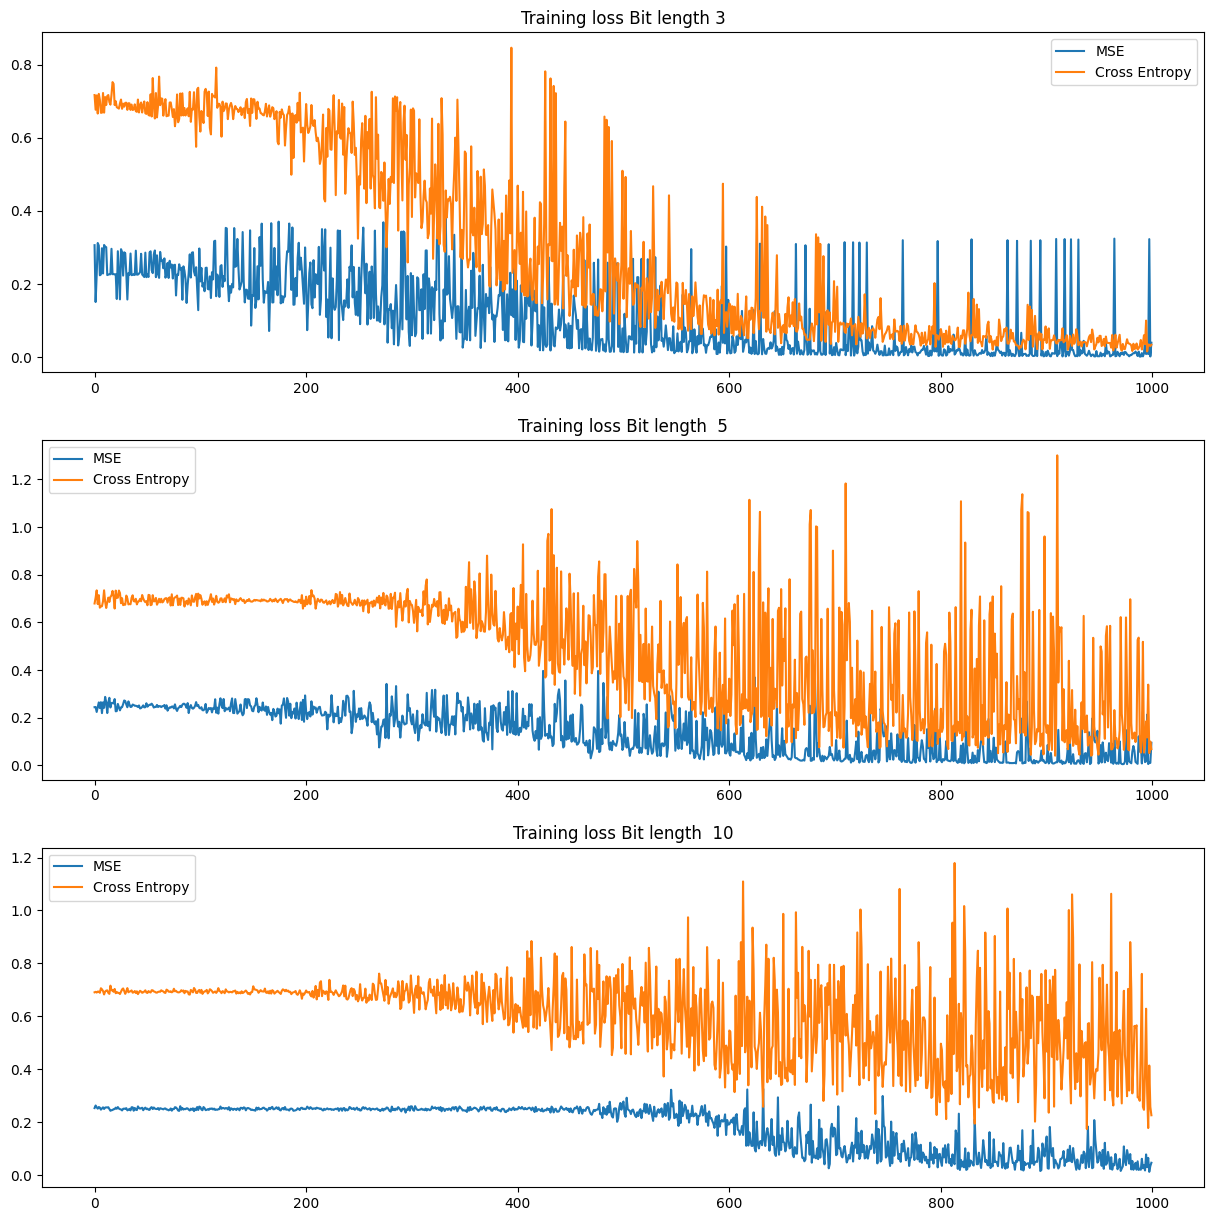

In [90]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))

model_3.plot(metric_bin_3["train_loss"],label = "MSE")
model_3.plot(metric_bin_3_ce["train_loss"],label = "Cross Entropy")
model_3.title.set_text("Training loss Bit length 3")
model_3.legend()

model_5.plot(metric_bin_5["train_loss"],label = "MSE")
model_5.plot(metric_bin_5_ce["train_loss"],label = "Cross Entropy")
model_5.legend()
model_5.title.set_text("Training loss Bit length  5")

model_10.plot(metric_bin_10["train_loss"],label = "MSE")
model_10.plot(metric_bin_10_ce["train_loss"],label = "Cross Entropy")
model_10.legend()
model_10.title.set_text("Training loss Bit length  10")

Cross entropy performs worse than mean squared error here.

## Bit Accuracy

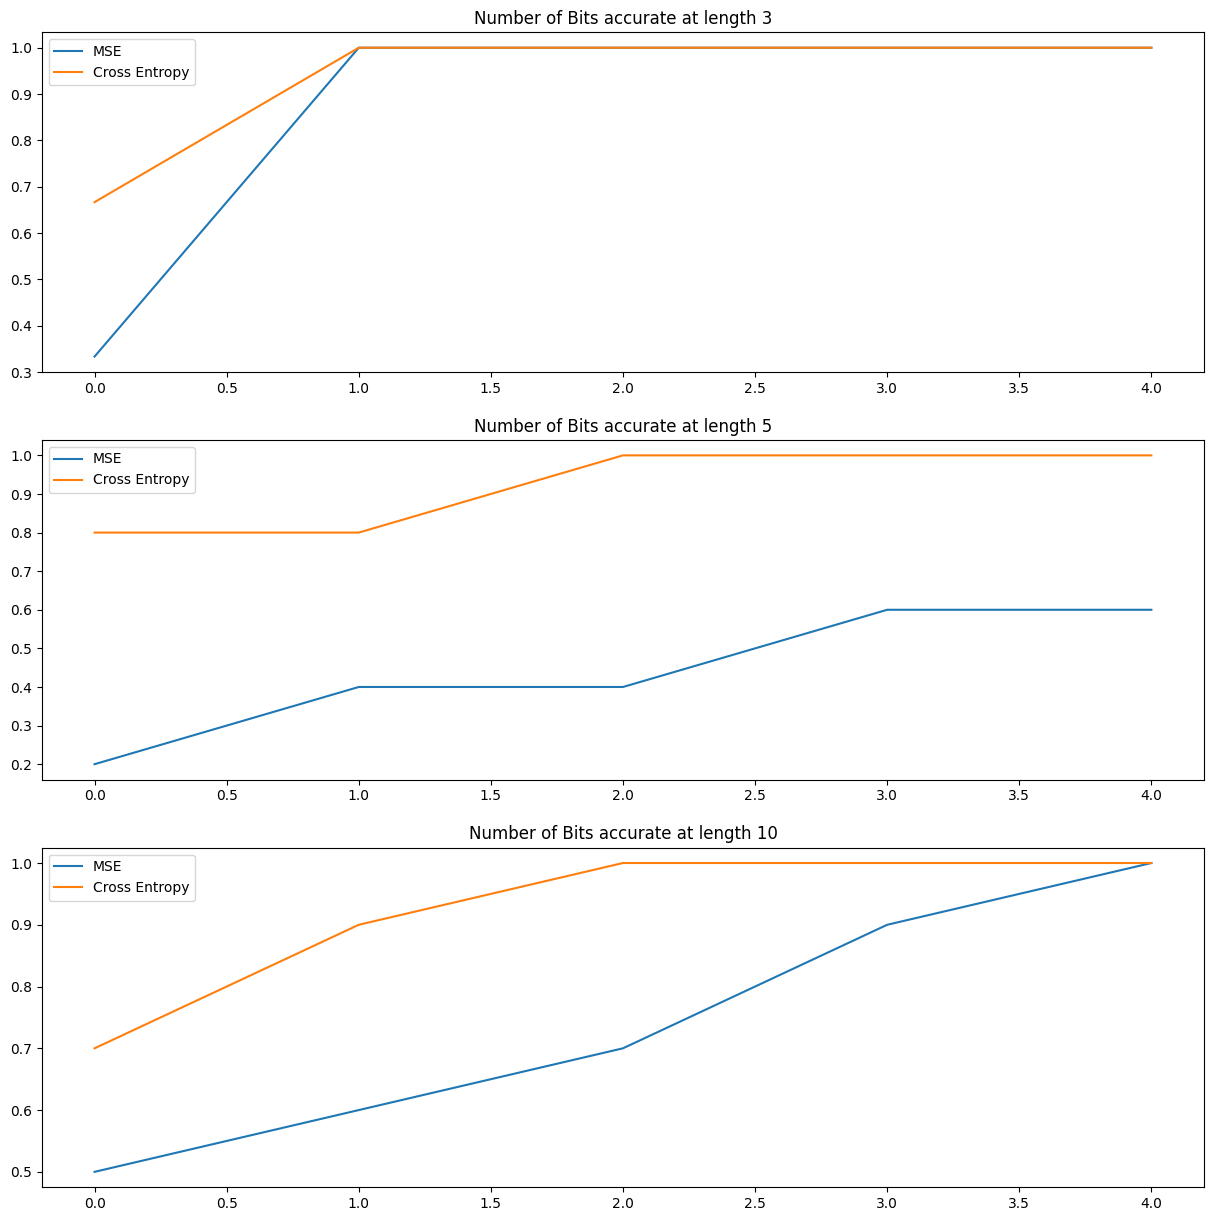

In [91]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))
model_3.plot(metric_bin_3["correct_test"],label = "MSE")
model_3.plot(metric_bin_3_ce["correct_test"],label = "Cross Entropy")
model_3.title.set_text("Number of Bits accurate at length 3")
model_3.legend()


model_5.plot(metric_bin_5["correct_test"],label = "MSE")
model_5.plot(metric_bin_5_ce["correct_test"],label = "Cross Entropy")
model_5.title.set_text("Number of Bits accurate at length 5")
model_5.legend()

model_10.plot(metric_bin_10["correct_test"],label = "MSE")
model_10.plot(metric_bin_10_ce["correct_test"],label = "Cross Entropy")
model_10.title.set_text("Number of Bits accurate at length 10")
model_10.legend()